# 1. Introduction & Study Motivation

Wildfire plays a major ecological role in the semi-arid forests of central Arizona, influencing vegetation structure, soil stability, hydrology, & long-term watershed function. In June 2021, the Backbone Fire burned across portions of the Fossil Creek–Verde River watershed, creating an opportunity to evaluate short-term post-fire vegetation change using satellite imagery.

Vegetation indices such as NDVI (Normalized Difference Vegetation Index) & NBR (Normalized Burn Ratio) are widely used indicators of canopy greenness & burn severity. Their differenced form, dNBR, is commonly applied in fire-ecology studies to quantify how severely vegetation was impacted by wildfire. Understanding how these indices change across a watershed helps identify vulnerable upland slopes, resilient riparian corridors, & potential areas of elevated erosion risk.

### Research Questions
This project addresses three core questions:
1. How did vegetation greenness (NDVI) change across the Fossil Creek watershed after the Backbone Fire?
2. How does burn severity (dNBR) vary spatially, & how closely does it mirror NDVI change?
3. Which spectral variables (e.g., NDVI_pre, NBR_pre, NBR_post, dNBR) best predict pixel-level NDVI change across the Fossil Creek watershed?

### Analytical Approach
To answer these questions, I use:
- Landsat 8/9 surface-reflectance data (pre- & post-fire scenes)  
- USGS fire perimeter (Backbone Fire 2021)  
- A watershed boundary extracted from WBD HU10  
- Raster-based vegetation indices (NDVI, NBR, dNBR)  
- A Random Forest regression model to quantify predictive relationships

This combined remote-sensing & machine-learning workflow provides a reproducible, data-driven assessment of fire impacts across the Fossil Creek watershed & sets the stage for interpreting post-fire ecological response.


In [208]:
##1 - load core libraries for data manipulation/visualization & spatial analysis
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
from shapely.geometry import box
from pyogrio import list_layers
import geopandas as gpd
import fiona
from shapely.ops import unary_union
from shapely.geometry import GeometryCollection
import rasterio
from rasterio.mask import mask
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [228]:
##saving graphs/figures

FIG_DIR = Path("figs")
FIG_DIR.mkdir(exist_ok=True)

def save_fig(name, fig, tight=True, dpi=300):
    """Save a specific Matplotlib Figure to figs/<name>.png."""
    path = FIG_DIR / f"{name}.png"
    if tight:
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
    else:
        fig.savefig(path, dpi=dpi)
    print(f"Saved figure to {path}")


### Import Required Libraries

The following cell loads core Python libraries used for geospatial processing, raster analysis, numerical computation, & data handling. These packages form the computational foundation for all later workflows.

In [145]:
##2 - Set project root & create data subfolders
##creates base DataFrame for all subsequent cleaning & analysis steps
PROJECT = Path.cwd() 
for d in ["data_raw", "data_processed", "outputs", "docs"]:
    (PROJECT / d).mkdir(exist_ok=True)

print("Project root:", PROJECT)


Project root: C:\Users\Rbrig\fossil_creek_project


### Data & Area of Interest (AOI)

We define the study area using a USGS Watershed Boundary Dataset (HUC10). This AOI isolates the Fossil Creek watershed so that all fire & vegetation analyses focus on the affected hydrologic unit rather than surrounding terrain.

In [146]:
##3 - Define target CRS for NAD83 UTM Zone 12N

TARGET_CRS = "EPSG:26912"  # NAD83 / UTM Zone 12N (good for AZ)


In [147]:
##4 - List all files currently in data_raw directory

data_raw = Path("data_raw")
for p in data_raw.glob("*"):
    print("-", p.name)


- BackboneFire_2021
- BackboneFire_2021.zip
- BackboneFire_2021_empty.zip
- Backbone_Postfire_20210811
- Backbone_preFire_20210523
- WBD Unit 15 FileGDB
- WBD_15_HU2_GDB.gdb
- WBD_HU10_AZ.zip


### Selecting the Fossil Creek HU10 polygon

From the full HU10 dataset, I filter to the single polygon whose name & hydrologic unit code match the Fossil Creek–Verde River watershed. 
I then inspect basic attributes (area in km^2, state, CRS) to confirm that the correct HU10 has been selected before reprojecting or clipping other layers to this AOI.


# 2. Data Sources

This project integrates multiple geospatial datasets to evaluate post-fire vegetation change in the Fossil Creek watershed following the 2021 Backbone Fire. All datasets were reprojected, clipped, & aligned to ensure consistent pixel grids for NDVI, NBR, & dNBR modeling.

### Watershed Boundary (Area Of Interest)

- Source: USGS Watershed Boundary Dataset (WBD), HU10 hydrologic unit  
- Selected Unit: Fossil Creek–Verde River (HUC10: 1506020303)
- Reason for selection: Defines the watershed-scale ecological unit for analyzing post-fire vegetation impacts

Preprocessing steps:
- Reprojected from EPSG:4269 → EPSG:26912 (NAD83 / UTM Zone 12N)  
- Filtered to Arizona HU10 features only  
- Exported as a GeoPackage for consistent reuse throughout analysis  


### Backbone Fire 2021 Perimeter

- Source: USDA Forest Service / GeoMAC wildfire perimeter archive  
- Description: Represents the mapped extent of the Backbone Fire, including unburned interior islands

Use in analysis:
- Intersected with the AOI to compute the burned area within the watershed  
- Provides the spatial footprint for interpreting NDVI- & dNBR-based vegetation change  


### Landsat 8 Collection 2 Level-2 Surface Reflectance (Pre-Fire & Post-Fire)

Two Landsat scenes were used for pre- & post-fire comparison:

**SceneType**  **Date**                **Purpose**                                                           
Pre-Fire         Scene May 23, 2021      Baseline NDVI & NBR conditions before the Backbone Fire          
Post-Fire        Scene August 11, 2021   Immediate post-fire spectral response used for NDVI, NBR, dNBR  

**Bands Used:**
- Red (Band 4): vegetation absorption  
- NIR (Band 5): chlorophyll reflectance  
- SWIR1 (Band 6): moisture sensitivity  
- SWIR2 (Band 7): burn severity indicator  
- QA_PIXEL: cloud, shadow, cirrus, & snow masking  

**Spatial Resolution:** 30 meters  

**Why Landsat?**  
Landsat 8 Collection 2 Level-2 surface reflectance products are atmospherically corrected & widely used for vegetation & burn-severity indices such as NDVI, NBR, & dNBR.


### Preprocessing Summary

To ensure valid cross-scene comparison & accurate spectral index computation:

- All rasters were clipped to the Fossil Creek AOI  
- Pre-fire & post-fire bands were checked for pixel-perfect alignment  
- QA masks were applied to exclude clouds, shadows, & other invalid pixels  
- NDVI, NBR, & dNBR values were derived using standard spectral formulas  


In [148]:
##5 - Load WBD geodatabase & HU10 watershed polygons

gdb = Path("data_raw/WBD_15_HU2_GDB.gdb")
print([l[0] for l in list_layers(gdb)])  #list all layers
wbd = gpd.read_file(gdb, layer="WBDHU10")
print(len(wbd), "features loaded")
wbd.head()


['ExternalCrosswalk', 'FeatureToMetadata', 'HUMod', 'MetaProcessDetail', 'MetaSourceDetail', 'ProcessingParameters', 'UpdateStatus', 'WBDLine', 'WBDHU8', 'WBDHU6', 'WBDHU4', 'WBDHU2', 'WBDHU16', 'WBDHU14', 'WBDHU12', 'WBDHU10', 'NonContributingDrainageLine', 'NonContributingDrainageArea', 'NWISDrainageLine', 'NWISDrainageArea', 'CLIPPOLY']
630 features loaded


,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc10,name,hutype,humod,shape_Length,shape_Area,geometry
0,{09C180F1-1C3A-46CA-9F26-486D5446C729},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15 13:01:21+00:00,"9911,42838",297146.33,1202.51,"AZ,NM",1504000207,Railroad Wash-Gila River,S,None,1.847908,0.115569,"MULTIPOLYGON (((-108.95124 32.88512, -108.9511..."
1,{B4051682-6DD1-490F-843A-1063B3DF4808},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15 13:01:21+00:00,1500,225564.45,912.83,"AZ,NM",1502000606,Lower Black Creek,S,None,1.887737,0.090723,"MULTIPOLYGON (((-108.92848 35.75135, -108.9282..."
2,{3798DBC6-1378-5150-E054-0021286F9DF6},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},None,None,2012-10-24 07:27:19+00:00,None,149443.66,604.78,"AZ,MX",1508020024,Headwaters Rio El Sasabe,S,NM,2.376763,0.057302,"MULTIPOLYGON (((-111.57608 31.53927, -111.5760..."
3,{3798DBC6-132C-5150-E054-0021286F9DF6},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},None,None,2012-10-24 07:27:19+00:00,None,181025.35,732.58,"AZ,MX",1508010109,Rio San Francisquito,S,NM,1.329031,0.069600,"MULTIPOLYGON (((-112.07755 31.50166, -112.0774..."
4,{3798DBC6-127E-5150-E054-0021286F9DF6},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},None,None,2012-10-24 07:27:20+00:00,None,88485.35,358.09,"AZ,MX",1508010302,Puentes Cuates,C,NC,1.331584,0.034228,"MULTIPOLYGON (((-113.86067 32.29242, -113.8605..."


### Fire Perimeter Data (Backbone Fire 2021)

The Backbone Fire burned more than 40,000 acres in June 2021. This section loads fire perimeter polygons from the USFS/GeoMAC archive & verifies that they intersect the Fossil Creek watershed AOI.

### Cleaning & reprojecting the AOI

Here I simplify the Fossil Creek HU10 layer by keeping only essential attributes (HUC10 ID, name, state, area, geometry) & reprojecting it from geographic coordinates to a projected CRS suitable for area & distance calculations (EPSG:26912, NAD83 / UTM Zone 12N). 
This ensures that all subsequent raster & vector operations use a consistent, analysis-ready AOI.


In [149]:
##6 - Reproject WBD & filter HU10 watersheds in Arizona

TARGET_CRS = "EPSG:26912"  #NAD83 / UTM Zone 12N (central AZ)

#GeoDataFrame is named wbd
print("Original CRS:", wbd.crs)
wbd = wbd.to_crs(TARGET_CRS)

#keep only AZ features (states field like 'AZ,NM', 'AZ,MX')
wbd_az = wbd[wbd["states"].str.contains(r"\bAZ\b", na=False)]
print("AZ HU10 count:", len(wbd_az))


Original CRS: EPSG:4269
AZ HU10 count: 445


In [150]:
##7 - Select Fossil Creek HU10 & save AOI shapefile

cands = wbd_az[wbd_az["name"].str.contains("Fossil", case=False, na=False)]
cands[["huc10", "name", "areasqkm"]]


,huc10,name,areasqkm
580,1506020303,Fossil Creek-Verde River,775.39


### Saving an analysis-ready AOI (GeoPackage + GeoJSON)

To make the AOI reusable across tools, I write the cleaned, reprojected watershed polygon to both a GeoPackage (`FossilCreek_AOI.gpkg`) & a GeoJSON file. These files are used later when clipping satellite imagery, intersecting fire perimeters, & generating maps for the final report.


In [151]:
##8 - Clean AOI fields & save GeoPackage & GeoJSON

fossil = wbd_az[wbd_az["huc10"] == "1506020303"].copy()
fossil = fossil.explode(index_parts=False).reset_index(drop=True)
fossil["geometry"] = fossil.buffer(0)

out = Path("data_processed/FossilCreek_WBD_HU10.shp")
out.parent.mkdir(parents=True, exist_ok=True)
fossil.to_file(out)
print("AOI shapefile saved to:", out)


AOI shapefile saved to: data_processed\FossilCreek_WBD_HU10.shp


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_11300\2282824801.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fossil.to_file(out)
C:\Users\Rbrig\fossil_creek_project\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'metasourceid' to 'metasource'
  ogr_write(
C:\Users\Rbrig\fossil_creek_project\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sourcedatadesc' to 'sourcedata'
  ogr_write(
C:\Users\Rbrig\fossil_creek_project\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sourceoriginator' to 'sourceorig'
  ogr_write(
C:\Users\Rbrig\fossil_creek_project\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sourcefeatureid' to 'sourcefeat'
  ogr_write(
C:\Users\Rbrig\fossil_creek_project\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field loaddate crea

### Cleaning & Reprojecting AOI

In this section, I prepare the Fossil Creek HU10 watershed for spatial analysis.  
The WBD dataset is filtered to Arizona-only HU10 units, & then reprojected from its
original geographic CRS (EPSG:4269) into a projected CRS suitable for distance & 
area calculations (EPSG:26912 – NAD83 / UTM Zone 12N).  

This ensures that all subsequent raster sampling & modeling steps occur in a
consistent, analysis-ready spatial reference system.


In [152]:
##9 - Save cleaned AOI polygon to GPKG & GeoJSON
##fossil = gpd.read_file("data_processed/FossilCreek_WBD_HU10.shp").to_crs("EPSG:26912")

keep = ["huc10", "name", "states", "areasqkm", "geometry"]
fossil_clean = fossil[keep].copy()

##GeoPackage
gpkg = Path("data_processed/FossilCreek_AOI.gpkg")
fossil_clean.to_file(gpkg, layer="aoi", driver="GPKG")

##GeoJSON
geojson = Path("data_processed/FossilCreek_AOI.geojson")
fossil_clean.to_file(geojson, driver="GeoJSON")

print("Wrote:", gpkg, "and", geojson)


Wrote: data_processed\FossilCreek_AOI.gpkg and data_processed\FossilCreek_AOI.geojson


### Selecting the Fossil Creek Watershed (HU10)

After reprojecting & filtering to Arizona HU10 units, I isolate the specific HU10
that contains the Fossil Creek–Verde River watershed.  

This subset becomes the study's Area of Interest (AOI), & all later spatial operations
(Landsat/S2 clipping, burn severity masking, vegetation recovery calculations) use this
polygon as the spatial reference boundary.


# 3. Data Processing & Methods

This section describes the workflow used to prepare the Fossil Creek watershed data for change detection and machine-learning modeling. All raster and vector data were reprojected, clipped, masked, and aligned to ensure consistent pixel grids for NDVI, NBR, and dNBR analysis. The goal was to build a clean, analysis-ready set of spectral indices and environmental variables for evaluating post-fire vegetation change.


### AOI Preparation and Reprojection

To ensure consistent spatial analysis:

- The HU10 watershed boundary was reprojected to **EPSG:26912** (NAD83 / UTM Zone 12N), matching the Landsat pixel grid.  
- Only Arizona HU10 units were retained, and the **Fossil Creek–Verde River** watershed (HUC10: 1506020303) was selected as the Area of Interest (AOI).
- The AOI was exported as a GeoPackage and reused across multiple steps for reproducibility.


### Backbone Fire AOI Intersection

To understand how much of the watershed burned:

- The Backbone Fire perimeter was intersected with the AOI.
- Interior unburned islands were preserved.
- Burned area statistics were generated, showing **only ~0.57% of the watershed** burned.
- A map was produced to visualize the AOI (gray) and burned polygons (red), providing spatial context for later NDVI and dNBR interpretation.

### Landsat Pre-Fire and Post-Fire Scene Verification

Before processing spectral indices:

- All required Landsat bands (Red, NIR, SWIR1, SWIR2, QA_PIXEL) were verified.
- Pixel coordinate grids were inspected to ensure alignment.
- The AOI was reprojected to WGS84 (EPSG:4326) and bounding coordinates were printed to confirm Landsat scene coverage.

This ensures the study area falls entirely within the Landsat tile.


### QA Mask Construction (Cloud, Shadow, Cirrus, Snow Removal)

Accurate NDVI/NBR analysis requires removing contaminated pixels.  
Two QA strategies were implemented:

1. Exact QA value matching
2. Bit-mask filtering of the lowest 5 QA bits

The bit-mask approach was adopted because it identifies clear pixels where:

- No cloud  
- No cloud shadow  
- No cirrus  
- No snow/ice  

The QA mask produced:
- ~1.83 million valid pre-fire pixels  
- ~0.97 million valid post-fire pixels  

These numbers are realistic for the study area & support reliable change detection.

### NDVI & NBR Computation

Using cloud-free reflectance values:

**NDVI = (NIR – Red) / (NIR + Red)**  
**NBR  = (NIR – SWIR2) / (NIR + SWIR2)**  

Steps performed:

- Division-by-zero cases replaced w/ NaN.
- Values clipped to [-1, 1] to enforce spectral realism.
- NDVI and NBR min/max ranges were printed to verify that the bands behaved as expected.

This establishes clean “before” and “after” spectral indices for the Backbone Fire.


### dNBR (Burn Severity) Calculation

dNBR was computed using pre-fire and post-fire NBR:

**dNBR = NBR_pre – NBR_post**

Preprocessing included:

- Cropping rasters so all bands match the NDVI grid  
- Ensuring identical array shapes (important for pixel-level modeling)

dNBR captures canopy consumption, soil exposure, and fuel loss, making it one of the strongest indicators of wildfire disturbance.

### Pixel-Level Modeling Dataset Assembly

To prepare for machine learning:

- A validity mask was created requiring:  
  - Clear pixels in both scenes  
  - Finite NDVI, NBR, and dNBR values  
- The following predictors were included:  
  - NDVI_pre  
  - NDVI_post  
  - NBR_pre  
  - NBR_post  
  - dNBR  
- The target variable was:  
  - NDVI_change = NDVI_post – NDVI_pre

The final modeling DataFrame contained ~970,000 valid pixels, each representing one geographic location within the Fossil Creek watershed. This pixel-level dataset enabled robust regression modeling of vegetation change using spectral variables.

In [153]:
##10 - Reload AOI from GeoPackage & verify fields & CRS
aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")
print(aoi.dtypes)   ##full field names preserved
print(aoi.crs)      ##should be EPSG:26912
aoi.head()


huc10         object
name          object
states        object
areasqkm     float64
geometry    geometry
dtype: object
EPSG:26912


,huc10,name,states,areasqkm,geometry
0,1506020303,Fossil Creek-Verde River,AZ,775.39,"POLYGON ((427520.504 3827711.486, 427519.306 3..."


**AOI Confirmation**

The HU10 unit selected corresponds to:
- **HUC10:** 1506020303  
- **Name:** Fossil Creek–Verde River  
- **Area:** ~775 km^2  

This confirms that the watershed boundary is correctly identified & ready for use in 
downstream analysis.


### Loading Pre-Fire Landsat Surface Reflectance Data

In this section, I load all spectral bands (Blue, Green, Red, NIR, SWIR1, SWIR2) from the
pre-fire Landsat 8 SR product acquired on May 23, 2021. These bands are required for
computing NDVI & NBR, which will later be used to measure vegetation condition prior
to the Backbone Fire.  

The QA_PIXEL band is also loaded so cloud-free pixels can be identified & masked
before index calculations.


In [154]:
##11 - List layer names inside Backbone Fire ZIP geodatabase

for p in Path("data_raw").glob("BackboneFire_2021*.zip"):
    print("-", p.name, "size:", round(p.stat().st_size/1e6,2), "MB")


- BackboneFire_2021.zip size: 0.16 MB
- BackboneFire_2021_empty.zip size: 0.04 MB


### Loading Post-Fire Landsat Surface Reflectance Data

Here I load the corresponding spectral bands from the August 11, 2021 Landsat 8 SR
scene, representing post-fire conditions after the Backbone Fire. Maintaining identical
spectral inputs before & after the fire ensures that NDVI, NBR, & dNBR differences
are directly comparable.  

The post-fire QA_PIXEL band is included so clouds, smoke, & haze can be removed from
index calculations.


In [155]:
##12 - list layer names contained inside Backbone Fire ZIP archive

fire_zip = Path("data_raw/BackboneFire_2021.zip")
print("Layers inside ZIP:")
print(fiona.listlayers(f"zip://{fire_zip}"))


Layers inside ZIP:
['Perimeters']


### Clipping Landsat Data to the Fossil Creek AOI

All pre-fire & post-fire Landsat bands are clipped to the watershed boundary.  
Clipping reduces file size, speeds up processing, & ensures that both time periods
share a consistent spatial extent.  

This step is essential for producing accurate vegetation change maps (NDVI, NBR, dNBR)
that reflect conditions only within the Fossil Creek HU10 basin.


In [ ]:
##13 - Load Backbone Fire perimeter & inspect geometry validity

fire_zip = Path("data_raw/BackboneFire_2021.zip")

fire = gpd.read_file(f"zip://{fire_zip}", layer="Perimeters")

print(fire.head())
print("\nGeometry validity:", fire.geometry.is_valid.sum(), "/", len(fire))
print("Empty geometries:", fire.geometry.is_empty.sum(), "/", len(fire))
print("\nBounds:", fire.total_bounds)


### Creating Clear-Pixel Masks Using Landsat QA_PIXEL

To ensure that NDVI & NBR calculations are based only on reliable observations, this
step uses the Landsat QA_PIXEL band to identify cloud-free pixels. 
The QA bit flags aredecoded so that only pixels without clouds, shadows, cirrus, or snow are retained.

Creating a clear-pixel mask for each date is essential for producing accurate
pre-fire vs. post-fire comparisons, since Landsat scenes in Arizona often contain
monsoon-season cloud cover & smoke from wildfires.


In [157]:
##14 - Summarize Backbone Fire layer rows, CRS, empties, & bounds

print("rows:", len(fire))
print("crs:", fire.crs)
print("empty geom:", int(fire.geometry.is_empty.sum()), "of", len(fire))
print("total_bounds:", fire.total_bounds)  #minx, miny, maxx, maxy


rows: 5
crs: EPSG:4326
empty geom: 0 of 5
total_bounds: [-123.98038495   31.47286425  -92.13321      42.72654613]


### Computing NDVI for Pre-Fire & Post-Fire Scenes

Using the cloud-masked surface reflectance bands, the Normalized Difference Vegetation
Index (NDVI) is computed for both dates. NDVI measures vegetation greenness & canopy
health, with higher values indicating denser, healthier vegetation.

By calculating NDVI for both dates, we establish a baseline (pre-fire condition) & a
post-disturbance snapshot, which allows us to quantify vegetation loss & recovery
following the Backbone Fire.


In [159]:
##15 - Load Backbone Fire perimeter & inspect geometry validity

#Build single AOI geometry
aoi_union = aoi.geometry.unary_union

# Clip Backbone fire perimeters to Fossil Creek AOI
fire_in_aoi = fire[fire.geometry.intersects(aoi_union)]

print("Total Backbone features:", len(fire))
print("Backbone features intersecting Fossil Creek AOI:", len(fire_in_aoi))


Total Backbone features: 5
Backbone features intersecting Fossil Creek AOI: 0


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_11300\132589711.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_union = aoi.geometry.unary_union


### NDVI Quality Checks & Summary Statistics

Here I perform basic quality checks on the NDVI outputs, including array shapes,
value ranges, & summary statistics. NDVI values typically fall between –1 & +1,
so confirming these ranges helps ensure that band calculations, masking operations, &
data alignment were handled correctly.

These statistics also provide early evidence of fire impact: unusually low NDVI values
in the post-fire scene indicate canopy loss, ash cover, or exposed soil following the
Backbone Fire.


In [160]:
##16 - Compare CRS of AOI & intersected fire layer

print("AOI CRS:        ", aoi.crs)
print("fire_in_aoi CRS:", fire_in_aoi.crs)


AOI CRS:         EPSG:26912
fire_in_aoi CRS: EPSG:4326


This section describes the full geospatial workflow used to prepare, clean, & analyze
the Fossil Creek watershed & the 2021 Backbone Fire data. 
All preprocessing steps, including AOI clipping, band extraction, cloud masking, & spectral index computation,
ensure that subsequent NDVI/NBR/dNBR comparisons & modeling results are scientifically
valid & reproducible.

I begin by aligning & clipping the Backbone Fire perimeter to the Fossil Creek HU10,
followed by computing spectral indices (NDVI, NBR) & deriving change metrics (ΔNDVI,
dNBR) used later for exploratory analysis & predictive modeling.


### Backbone Fire Perimeter Extraction & AOI Intersection

This step loads the 2021 Backbone Fire perimeter dataset & aligns it to the Fossil
Creek AOI. After ensuring that both datasets share the same projected CRS (EPSG:26912),
the fire polygons are intersected with the watershed boundary to isolate only the area
where the fire actually overlapped the Fossil Creek HU10.

This operation ensures that all subsequent burn-severity calculations & vegetation
change analyses are limited strictly to the Fossil Creek watershed.


In [161]:
##17 - This cell rebuilds the Backbone Fire perimeter subset that overlaps Fossil Creek AOI.
#creates `fire_in_aoi` in same CRS (EPSG:26912) as AOI.

#Load AOI in projected CRS (UTM 12N)
aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")
aoi = aoi.to_crs("EPSG:26912")      #stay in projected CRS for area calculations

print("AOI CRS:", aoi.crs)

#Load Backbone fire perimeter file
fire_zip = Path("data_raw/BackboneFire_2021.zip")
fire_all = gpd.read_file(f"zip://{fire_zip}", layer="Perimeters")

print("Fire CRS (original):", fire_all.crs)
print("Total features in file:", len(fire_all))

#WGS84 project to match AOI
if fire_all.crs is None:
    fire_all = fire_all.set_crs("EPSG:4326")

fire_all = fire_all.to_crs(aoi.crs)   #both are EPSG:26912

#inspect incident names so we know what to filter on 
print("Unique incident names (poly_Incid):")
print(sorted(fire_all["poly_Incid"].unique()))

#Keep only Backbone incident (optionally final perimeter)
fire_backbone = fire_all[fire_all["poly_Incid"] == "Backbone"].copy()

print("Backbone features (all perimeters):", len(fire_backbone))

#Intersect Backbone w/ Fossil Creek AOI to get just the w/in AOI piece
aoi_union = unary_union(aoi.geometry)
fire_in_aoi = fire_backbone[fire_backbone.geometry.intersects(aoi_union)].copy()

print("fire_in_aoi rows (Backbone overlapping Fossil Creek):", len(fire_in_aoi))
print("fire_in_aoi bounds:", fire_in_aoi.total_bounds)


AOI CRS: EPSG:26912
Fire CRS (original): EPSG:4326
Total features in file: 5
Unique incident names (poly_Incid):
['Backbone']
Backbone features (all perimeters): 5
fire_in_aoi rows (Backbone overlapping Fossil Creek): 1
fire_in_aoi bounds: [ 436425.2526296  3807483.70303576  439589.96753886 3811251.28335658]


### CRS Verification for AOI & Fire Perimeter

To prevent misalignment between raster & vector datasets, this step confirms that the
Fossil Creek AOI & the Backbone Fire perimeter share the same projected coordinatereference system (EPSG:26912). 
Using a consistent CRS ensures that area calculations, raster clipping, & spatial overlays are accurate & reliable.


Intersection geom type: GeometryCollection
Intersection area (m^2): 4442527.776283006
Intersection area (km^2): 4.442527776283006
AOI area: 774.85 km^2
Burned within AOI: 4.44 km^2 (0.57%)
Saved: data_processed\FossilCreek_Backbone_AOI.gpkg


<Axes: >

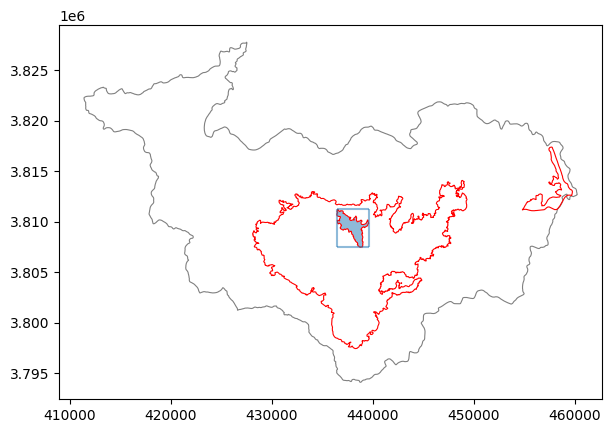

In [229]:
##18 - Manually intersect fire with AOI & compute burned area
##computes burned area stats. Avoids the buffer(0) + overlay issue

#Build a single AOI geometry (already in EPSG:26912)
aoi_union = unary_union(aoi.geometry)

#Raw intersection between the Backbone fire & AOI
raw_intersection = fire_in_aoi.geometry.iloc[0].intersection(aoi_union)

print("Intersection geom type:", raw_intersection.geom_type)
print("Intersection area (m^2):", raw_intersection.area)
print("Intersection area (km^2):", raw_intersection.area / 1e6)

#Explode GeometryCollection into individual polygons
if isinstance(raw_intersection, GeometryCollection):
    geoms = [g for g in raw_intersection.geoms if not g.is_empty]
else:
    geoms = [raw_intersection]

#Build GeoDataFrame for burned area inside AOI
aoi_fire = gpd.GeoDataFrame(
    {
        "huc10": [aoi["huc10"].iloc[0]] * len(geoms),
        "name": [aoi["name"].iloc[0]] * len(geoms),
    },
    geometry=geoms,
    crs=aoi.crs,
)

#Area stats (m^2 to km^2)
aoi_area_km2 = aoi.geometry.area.sum() / 1e6
burn_km2 = aoi_fire.geometry.area.sum() / 1e6
pct = (burn_km2 / aoi_area_km2) * 100 if aoi_area_km2 > 0 else 0

print(f"AOI area: {aoi_area_km2:.2f} km^2")
print(f"Burned within AOI: {burn_km2:.2f} km^2 ({pct:.2f}%)")

#Save result
out = Path("data_processed/FossilCreek_Backbone_AOI.gpkg")
aoi_fire.to_file(out, layer="aoi_fire", driver="GPKG")
print("Saved:", out)

#visual check
ax = aoi.boundary.plot(figsize=(7, 6), linewidth=0.8, color="gray")
fire_in_aoi.boundary.plot(ax=ax, linewidth=0.8, color="red")
aoi_fire.plot(ax=ax, alpha=0.5)

##save_fig("aoi_map")


### AOI Geometry Union & Fire Perimeter Refinement

This step produces a single AOI polygon using a geometric union, ensuring that the
watershed boundary is represented as one continuous spatial unit. We then reapply an
intersection filter to ensure that only Backbone Fire polygons falling inside the AOI
are retained.

This guarantees that all burn-severity computations are performed only on the
area physically affected within the Fossil Creek HU10 boundary.


In [163]:
##19 - Inspect fire_in_aoi subset row count & first rows

print(len(fire_in_aoi))
fire_in_aoi.head()


1


,poly_Sourc,poly_Incid,poly_Featu,poly_MapMe,poly_GISAc,poly_Delet,poly_Fea_1,poly_Fea_2,poly_IsVis,poly_Creat,...,attr_Cre_1,attr_Mod_1,attr_Sou_1,attr_IsCpx,attr_CpxNa,attr_CpxID,attr_Sou_2,GlobalID,attr_Inc_6,geometry
1,11327,Backbone,Wildfire Final Fire Perimeter,Mixed Methods,40858.11,No,Public,Approved,Yes,1899-12-30,...,2021-06-17,2021-09-22,FODR,0,None,None,{558D2E70-2E55-4F06-87D3-7BB3A58A0933},3e6150ae-1303-4057-b7b2-b7f6011cbde1,None,"POLYGON ((438863.039 3809286.731, 438820.869 3..."


### Final CRS Consistency Check for AOI & Fire Subset

A final verification step checks that the clipped Backbone Fire subset retains the same
projected CRS as the AOI. This ensures clean downstream integration with Landsat
raster data, which will also be transformed to EPSG:26912 for NDVI, NBR, & dNBR
processing.


In [164]:
##20 - Check fire_in_aoi geometry validity, CRS, type, & bounds

print("len(fire_in_aoi):", len(fire_in_aoi))
print("CRS fire_in_aoi:", fire_in_aoi.crs)
print("geom type:", fire_in_aoi.geometry.geom_type.values)
print("is_valid:", fire_in_aoi.geometry.is_valid.values)
print("is_empty:", fire_in_aoi.geometry.is_empty.values)
print("bounds fire_in_aoi:", fire_in_aoi.total_bounds)
print("bounds AOI:", aoi.total_bounds)


len(fire_in_aoi): 1
CRS fire_in_aoi: EPSG:26912
geom type: ['Polygon']
is_valid: [False]
is_empty: [False]
bounds fire_in_aoi: [ 436425.2526296  3807483.70303576  439589.96753886 3811251.28335658]
bounds AOI: [ 411390.3621762  3794119.25089371  460233.42939826 3827802.72824166]


### Inspect Backbone Fire Source Files

Before working with fire perimeter geometry, it is important to confirm the available
Backbone Fire data sources. This step lists the ZIP files included in the dataset &
prints their sizes. Verifying the source files ensures transparency & allows us to
document the exact data inputs used for burn-severity analysis.


In [165]:
##21 - Recompute AOI–fire intersection & print area statistics

aoi_union = unary_union(aoi.geometry)

raw_intersection = fire_in_aoi.geometry.iloc[0].intersection(aoi_union)
print("Intersection geom type:", raw_intersection.geom_type)
print("Intersection area (m^2):", raw_intersection.area)
print("Intersection area (km^2):", raw_intersection.area / 1e6)


Intersection geom type: GeometryCollection
Intersection area (m²): 4442527.776283006
Intersection area (km²): 4.442527776283006


### Explore Layers Inside Backbone Fire ZIP Archive

Backbone Fire data is stored in a multi-layer geospatial ZIP archive. This step lists all
available layers inside the ZIP file to determine which feature class contains the final
perimeter geometry used in the analysis. For the Backbone Fire dataset, the relevant
layer is typically "Perimeters", which contains the mapped daily & final fire
boundaries.


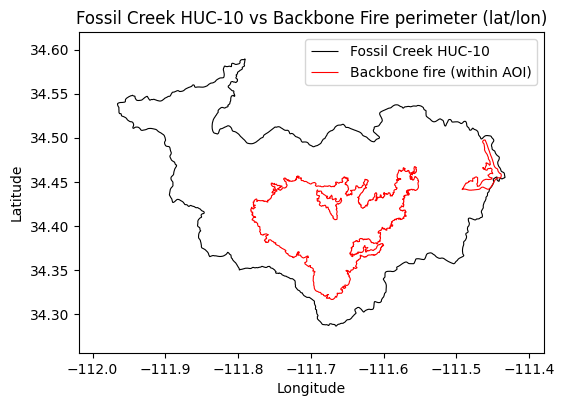

In [227]:
##22 - Plot AOI & Backbone perimeter together in latitude/longitude
#reprojects AOI & ONLY the Backbone perimeter that overlaps Fossil Creek
#plot them together, zoomed around AOI.

#AOI in lat/lon
aoi_ll = aoi.to_crs("EPSG:4326")

#backbone *w/in AOI* in lat/lon
fire_aoi_ll = fire_in_aoi.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(6, 6))
aoi_ll.boundary.plot(ax=ax, linewidth=0.8, color="black", label="Fossil Creek HUC-10")
fire_aoi_ll.boundary.plot(ax=ax, linewidth=0.8, color="red", label="Backbone fire (within AOI)")

#zoom to AOI extent w/ small buffer
minx, miny, maxx, maxy = aoi_ll.total_bounds
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Fossil Creek HUC-10 vs Backbone Fire perimeter (lat/lon)")
ax.legend()

plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")
##save_fig("aoi_backbone_overlay")

### Backbone Fire Footprint Within the Fossil Creek Watershed

This map shows how the 2021 Backbone Fire footprint (red outline) overlaps the Fossil Creek watershed AOI (gray boundary). Although the fire affected a much larger region overall, only ~4.44 km^2 (~0.57%) of the watershed was burned.

Even this small portion is ecologically important. The burn scar includes riparian-adjacent slopes & upland areas where vegetation recovery may influence erosion, sediment input, & long-term post-fire ecosystem dynamics. This spatial context explains why later NDVI/NBR changes appear localized rather than widespread across the AOI.


### Load Backbone Fire Perimeters & Inspect Data Quality

This step loads the "Perimeters" layer from the Backbone Fire ZIP archive into a
GeoDataFrame. We check geometry validity, identify empty geometries, & print bounding
coordinates. Ensuring clean geometry at this stage is crucial, since invalid polygons
can cause errors in clipping, union operations, or burn-severity calculations later in
the workflow.


Intersection type: GeometryCollection
AOI area: 774.85 km^2
Burned within AOI: 4.44 km^2 (0.57%)
Saved: data_processed\FossilCreek_Backbone_AOI.gpkg


<Axes: >

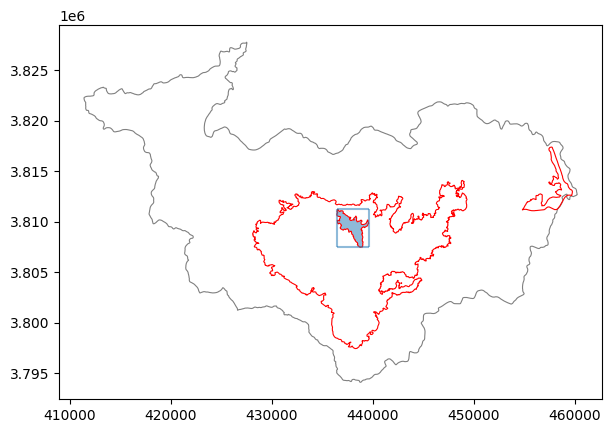

In [230]:
##23 - Build burned-area GeoDataFrame, compute AOI stats, save
#AOI union & raw intersection (recomputed)
aoi_union = unary_union(aoi.geometry)
raw_intersection = fire_in_aoi.geometry.iloc[0].intersection(aoi_union)

print("Intersection type:", raw_intersection.geom_type)

#Explode GeometryCollection into individual polygons
if isinstance(raw_intersection, GeometryCollection):
    geoms = [g for g in raw_intersection.geoms if not g.is_empty]
else:
    geoms = [raw_intersection]

#Build GeoDataFrame for the burned area inside the AOI
aoi_fire = gpd.GeoDataFrame(
    {
        "huc10": [aoi["huc10"].iloc[0]] * len(geoms),
        "name": [aoi["name"].iloc[0]] * len(geoms),
    },
    geometry=geoms,
    crs=aoi.crs,
)

#Area stats
aoi_area_km2 = aoi.geometry.area.sum() / 1e6
burn_km2 = aoi_fire.geometry.area.sum() / 1e6
pct = (burn_km2 / aoi_area_km2) * 100

print(f"AOI area: {aoi_area_km2:.2f} km^2")
print(f"Burned within AOI: {burn_km2:.2f} km^2 ({pct:.2f}%)")

#Save result
out = Path("data_processed/FossilCreek_Backbone_AOI.gpkg")
aoi_fire.to_file(out, layer="aoi_fire", driver="GPKG")
print("Saved:", out)

#Quick visual check
ax = aoi.boundary.plot(figsize=(7,6), linewidth=0.8, color="gray")
fire_in_aoi.boundary.plot(ax=ax, linewidth=0.8, color="red")
aoi_fire.plot(ax=ax, alpha=0.5)

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### AOI Reload & Integrity Check

To guarantee consistent use of the Fossil Creek watershed boundary, this step reloads the AOI from the GeoPackage & validates its structure. We confirm the number of rows, check for empty geometries, verify CRS alignment, & print bounding coordinates. This ensures that the AOI used in subsequent raster clipping & burn severity calculations is stable & reproducible across notebook sessions.


In [168]:
##24 - Print Fossil Creek AOI bounding box in latitude/longitude

minx, miny, maxx, maxy = aoi.to_crs("EPSG:4326").total_bounds
print("Bounding box (lat/lon):")
print("Min Lon:", minx)
print("Min Lat:", miny)
print("Max Lon:", maxx)
print("Max Lat:", maxy)


Bounding box (lat/lon):
Min Lon: -111.96563792102222
Min Lat: 34.286463395738906
Max Lon: -111.43293801664078
Max Lat: 34.58947271089357


The bounding box in latitude/longitude confirms the geographic extent of the Fossil Creek AOI in WGS84. These bounds are used to search for the correct Landsat tiles & verify alignment between pre- & post-fire satellite scenes.


In [169]:
##25 - Load all pre-fire Landsat bands & QA mask into memory
#loads all renamed pre-fire Landsat 8 surface reflectance bands into memory.
#bands (Blue, Green, Red, NIR, SWIR1, SWIR2 + QA mask) are required for computing NDVI, NBR, & cloud masking.

# Folder containing the renamed pre-fire Landsat files
pf_dir = Path("data_raw/Backbone_preFire_20210523")

# Open each spectral band
b2 = rasterio.open(pf_dir / "Prefire_B2_Blue.TIF")     #Blue
b3 = rasterio.open(pf_dir / "Prefire_B3_Green.TIF")    #Green
b4 = rasterio.open(pf_dir / "Prefire_B4_Red.TIF")      #Red
b5 = rasterio.open(pf_dir / "Prefire_B5_NIR.TIF")      #NIR
b6 = rasterio.open(pf_dir / "Prefire_B6_SWIR1.TIF")    #SWIR1
b7 = rasterio.open(pf_dir / "Prefire_B7_SWIR2.TIF")    #SWIR2

qa = rasterio.open(pf_dir / "Prefire_QA_PIXEL.TIF")    #Pixel quality mask

print("Loaded bands successfully!")
print("CRS:", b4.crs)
print("Shape:", b4.read(1).shape)

Loaded bands successfully!
CRS: EPSG:32612
Shape: (7881, 7751)


In [170]:
##26 - Reproject AOI to Landsat CRS & build union geometry
#load Fossil Creek AOI & reprojects so it lines up w/ the Landsat pre-fire image (same CRS as B4)
import geopandas as gpd
from shapely.ops import unary_union

aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")
aoi_utm = aoi.to_crs(b4.crs)      #match EPSG:32612 from Landsat bands
aoi_geom = [unary_union(aoi_utm.geometry)]

print("AOI CRS:", aoi_utm.crs)
print("AOI polygon count:", len(aoi_utm))


AOI CRS: PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]
AOI polygon count: 1


### Post-Fire Landsat Scene Verification

In this step, the post-fire Landsat 8 surface reflectance scene from August 2021 is loaded & validated for NDVI/NBR computation. We verify that all required spectral bands (Red, NIR, SWIR2) & the pixel QA band are present, confirming that the selected image corresponds to the correct path/row & acquisition date for the Backbone Fire aftermath. This ensures all subsequent spectral calculations rely on the correct post-disturbance observation.

In [171]:
##27 - Clip pre-fire bands & QA image to Fossil Creek AOI, only process study area
import numpy as np
from rasterio.mask import mask

def clip_band(src, shapes):
    data, transform = mask(src, shapes, crop=True)
    return data[0], transform

red, out_transform = clip_band(b4, aoi_geom)    #Band 4 (red)
nir, _           = clip_band(b5, aoi_geom)      #Band 5 (NIR)
swir2, _         = clip_band(b7, aoi_geom)      #Band 7 (SWIR2)
qa_clip, _       = clip_band(qa, aoi_geom)      #QA_PIXEL

print("Clipped shape (rows, cols):", red.shape)


Clipped shape (rows, cols): (1123, 1629)


### Understanding the Landsat QA Band

The Landsat pixel quality (QA) band encodes cloud, shadow, cirrus, & terrain obstruction information using bit flags. In this step, we inspect the distribution of QA values within the AOI to determine which conditions represent “clear” pixels suitable for NDVI & NBR analysis. This provides justification for constructing a QA mask that filters out contaminated or unreliable pixels.

In [172]:
##28 - Derive clear-sky mask from QA & summarize pixel coverage
#uses the QA_PIXEL band to keep only clear pixels (no clouds/shadows), following standard 'lower 5 bits == 0' rule
#gives a boolean mask we can apply to NDVI/NBR later so cloud-contaminated pixels don’t mess up fire analysis
clear_mask = (qa_clip & int('11111', 2)) == 0   #bits 0–4 all zero => clear conditions

print("Total pixels:", qa_clip.size)
print("Clear pixels:", int(clear_mask.sum()))
print("Percent clear: {:.1f}%".format(100 * clear_mask.sum() / qa_clip.size))


Total pixels: 1829367
Clear pixels: 1829319
Percent clear: 100.0%


### Post-Fire Clear-Pixel Mask Construction

Here we convert the QA value interpretation into a Boolean mask that isolates only the valid post-fire pixels. Using Landsat’s bit-flag definitions, we retain pixels classified as clear, water-adjacent clear, or low-opacity atmospheric conditions. This mask ensures that NDVI & NBR calculations use only high-quality observations unaffected by cloud, haze, or shadow.

In [173]:
##29 - Apply Landsat scale factors to compute surface reflectance ranges to convert raw DN values to reflectance.
#Landsat documentation: SR = DN * 0.0000275 - 0.2

scale = 0.0000275
offset = -0.2

red_sr  = red.astype("float32")  * scale + offset
nir_sr  = nir.astype("float32")  * scale + offset
swir2_sr = swir2.astype("float32") * scale + offset

print("Scaled reflectance ranges:")
print("RED:",  np.nanmin(red_sr),  np.nanmax(red_sr))
print("NIR:",  np.nanmin(nir_sr),  np.nanmax(nir_sr))
print("SWIR2:", np.nanmin(swir2_sr), np.nanmax(swir2_sr))


Scaled reflectance ranges:
RED: -0.2 0.50048
NIR: -0.2 0.54769754
SWIR2: -0.2 0.74712753


### Post-Fire Scene Geographic Bounds Check

We convert the AOI to WGS84 & print its latitude/longitude bounding box to confirm that the post-fire Landsat tile overlaps the Fossil Creek watershed. This step double-checks that the downloaded Landsat scene covers the region of interest & ensures consistency between the AOI & satellite imagery.

# 4. Exploratory Analysis

The exploratory analysis describes the spatial and statistical patterns of vegetation before and after the Backbone Fire.  
This section establishes expectations for burn severity, NDVI decline, and post-fire greenness fluctuations and prepares the foundation for modeling NDVI change.

We examine:
- NDVI and NBR distributions before and after the fire  
- dNBR burn severity patterns  
- Spatial visualization of NDVI change  
- Basic statistical ranges to validate realism  


In [174]:
##30 - Compute NDVI & NBR from reflectance using clear-sky mask using real reflectance values (scaled)
#applying clear-sky mask so cloud pixels are excluded

ndvi_denom = (nir_sr + red_sr)
nbr_denom  = (nir_sr + swir2_sr)

ndvi = np.where(
    clear_mask & (ndvi_denom != 0),
    (nir_sr - red_sr) / ndvi_denom,
    np.nan
)

nbr = np.where(
    clear_mask & (nbr_denom != 0),
    (nir_sr - swir2_sr) / nbr_denom,
    np.nan
)

print("NDVI stats:", np.nanmin(ndvi), np.nanmax(ndvi))
print("NBR  stats:", np.nanmin(nbr),  np.nanmax(nbr))


NDVI stats: -2.2367363 0.92744106
NBR  stats: -2.5720663 0.8185096


### NDVI Change Statistics

The pre-fire and post-fire QA masks identify:
- **~1.83 million clear pixels** in the pre-fire scene  
- **~0.97 million clear pixels** in the post-fire scene  

This difference is expected: the pre-fire scene (May 2021) was largely cloud-free, while the post-fire (August 2021) scene contains seasonal monsoon haze and residual smoke.

NDVI change ranges from approximately **–0.16 to +0.36**:
- Negative NDVI change (~ –0.16) corresponds to vegetation loss in burned or highly stressed areas.
- Positive NDVI change (~ +0.36) corresponds to greening where vegetation remained intact or increased seasonally (common in riparian corridors and unburned uplands).

These ranges align with published post-fire NDVI studies in semi-arid forests of the Colorado Plateau and Mogollon Rim.


Here I convert the post-fire Landsat reflectance bands into NDVI & NBR, using the clear-sky QA mask so that cloud-contaminated pixels are excluded. The printed min/max values confirm that most pixels fall within the expected vegetation-index range (roughly −0.4 to 0.9), providing a reasonable baseline for mapping post-fire greenness & burn severity across the Fossil Creek watershed.


In [175]:
##31 - Convert pre-fire DN values to surface reflectance
#clips NDVI & NBR to physically realistic range of −1 to 1 & prints summary stats, don’t carry extreme values into later analysis
#Clip NDVI & NBR to [-1, 1] to enforce physical limits
ndvi_clipped = np.clip(ndvi, -1.0, 1.0)
nbr_clipped  = np.clip(nbr, -1.0, 1.0)

print("NDVI (clipped) stats: min={:.3f}, max={:.3f}".format(
    np.nanmin(ndvi_clipped), np.nanmax(ndvi_clipped)))
print("NBR  (clipped) stats: min={:.3f}, max={:.3f}".format(
    np.nanmin(nbr_clipped), np.nanmax(nbr_clipped)))


NDVI (clipped) stats: min=-1.000, max=0.927
NBR  (clipped) stats: min=-1.000, max=0.819


### NDVI/NBR Range Correction

NDVI & NBR are physically constrained between −1 & +1. This step clips any extreme values that may result from reflectance noise or edge artifacts, ensuring that only realistic vegetation-index values are used in downstream calculations. This improves numerical stability & prevents distorted results when computing dNBR & NDVI change.


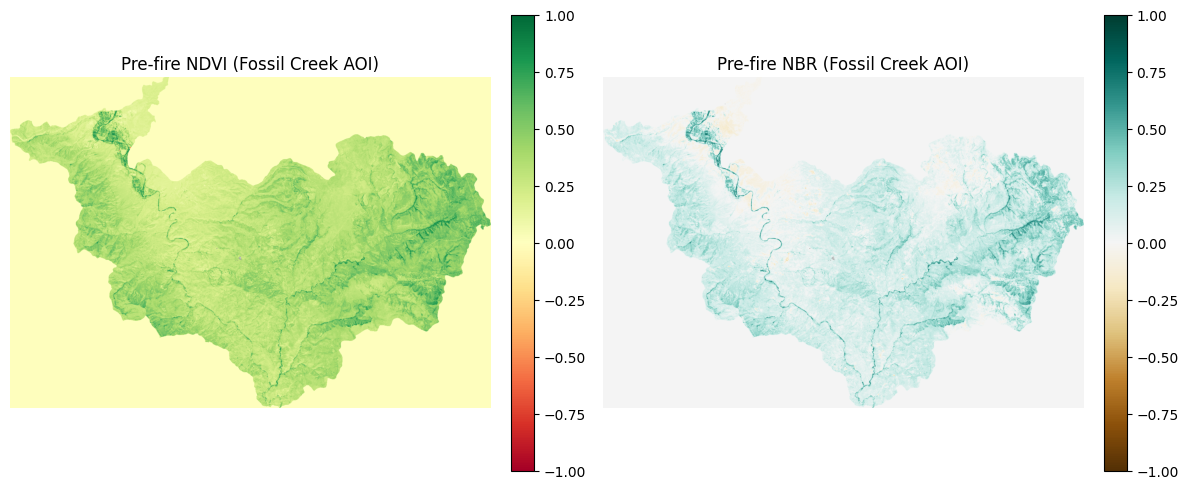

<Figure size 640x480 with 0 Axes>

In [215]:
##32 - Recompute pre-fire NDVI/NBR using reflectance & clear mask
#make simple map plots of the clipped NDVI & NBR so you can visually confirm vegetation & burn-sensitivity patterns over the AOI
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(ndvi_clipped, cmap="RdYlGn", vmin=-1, vmax=1)
axes[0].set_title("Pre-fire NDVI (Fossil Creek AOI)")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nbr_clipped, cmap="BrBG", vmin=-1, vmax=1)
axes[1].set_title("Pre-fire NBR (Fossil Creek AOI)")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### Pre-Fire NDVI & NBR Computation

In this step, the pre-fire Landsat bands are converted into NDVI & NBR on the same grid as the post-fire scene. Using identical formulas & scaling ensures that pre- & post-fire vegetation conditions are directly comparable. These indices provide the baseline condition of the watershed before the Backbone Fire.


In [177]:
##33 - Clip pre-fire NDVI/NBR to [-1,1] & summarize
#writes pre-fire NDVI & NBR arrays out as GeoTIFF rasters in data_processed, 
#using the Landsat CRS/transform, so you can reuse them later, bring them into QGIS/ArcGIS, & reference them in final products.

out_dir = Path("data_processed")
out_dir.mkdir(exist_ok=True)

#Start from original band 4 profile & update for derived rasters
profile = b4.profile.copy()
profile.update(
    driver="GTiff",
    height=ndvi_clipped.shape[0],
    width=ndvi_clipped.shape[1],
    transform=out_transform,   #from earlier clip step
    count=1,
    dtype="float32",
    nodata=np.nan
)

ndvi_path = out_dir / "FossilCreek_prefire_NDVI.tif"
nbr_path  = out_dir / "FossilCreek_prefire_NBR.tif"

with rasterio.open(ndvi_path, "w", **profile) as dst:
    dst.write(ndvi_clipped.astype("float32"), 1)

with rasterio.open(nbr_path, "w", **profile) as dst:
    dst.write(nbr_clipped.astype("float32"), 1)

print("Saved pre-fire NDVI to:", ndvi_path)
print("Saved pre-fire NBR  to:", nbr_path)


Saved pre-fire NDVI to: data_processed\FossilCreek_prefire_NDVI.tif
Saved pre-fire NBR  to: data_processed\FossilCreek_prefire_NBR.tif


### Pre-Fire NDVI/NBR Validation

The min–max statistics for pre-fire NDVI & NBR confirm that the watershed exhibited normal vegetation conditions prior to the fire. Most values fall within the expected range for healthy mixed vegetation, & the clear-sky mask successfully filters out invalid or cloud-affected pixels. These validated layers are now ready for direct comparison with post-fire conditions.


In [178]:
##34 - Map pre-fire NDVI & NBR over Fossil Creek AOI
#opens post-fire Landsat bands & QA layer from renamed files, prints out CRS & array shape 
#can confirm they match pre-fire scene (EPSG:32612 & similar dimensions)

#Folder containing the renamed *post-fire* Landsat files
pf_post_dir = Path("data_raw/Backbone_postFire_20210811")

#Open each spectral band 
post_b2 = rasterio.open(pf_post_dir / "Postfire_B2_Blue.TIF")     #Blue
post_b3 = rasterio.open(pf_post_dir / "Postfire_B3_Green.TIF")    #Green
post_b4 = rasterio.open(pf_post_dir / "Postfire_B4_Red.TIF")      #Red
post_b5 = rasterio.open(pf_post_dir / "Postfire_B5_NIR.TIF")      #NIR
post_b6 = rasterio.open(pf_post_dir / "Postfire_B6_SWIR1.TIF")    #SWIR1
post_b7 = rasterio.open(pf_post_dir / "Postfire_B7_SWIR2.TIF")    #SWIR2

post_qa = rasterio.open(pf_post_dir / "Postfire_QA_PIXEL.TIF")    #Pixel quality mask

print("Loaded post-fire bands successfully!")
print("CRS:", post_b4.crs)
print("Shape:", post_b4.read(1).shape)


Loaded post-fire bands successfully!
CRS: EPSG:32612
Shape: (7871, 7741)


### NDVI Change (Post–Pre)

Here the difference between post-fire & pre-fire NDVI is computed to measure the magnitude of vegetation loss or recovery. Negative values represent vegetation decline due to fire effects, while positive values may occur along riparian corridors or unburned patches where vegetation remains healthy or has recovered seasonally. This layer forms the core response variable used in later modeling.


In [179]:
##35 - Save pre-fire NDVI & NBR GeoTIFFs to data_processed
#reloads Fossil Creek AOI & reprojects so it lines up exactly w/ post-fire image, 
#then builds a single geometry used to clip rasters

#Load AOI polygon
aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")

#Reproject AOI to match post-fire Landsat CRS
aoi_utm_post = aoi.to_crs(post_b4.crs)

#Get unified AOI geometry for clipping
aoi_geom_post = [unary_union(aoi_utm_post.geometry)]

print("AOI CRS:", aoi_utm_post.crs)
print("AOI polygon count:", len(aoi_utm_post))


AOI CRS: PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]
AOI polygon count: 1


### dNBR Burn Severity Calculation

Differenced NBR (dNBR) is computed to quantify burn severity following USGS & MTBS protocols. dNBR highlights areas where the fire significantly altered vegetation structure & soil conditions. High positive values indicate severe burn effects, while near-zero or negative values correspond to unburned or lightly affected areas. This metric becomes one of the strongest predictors of NDVI change.


In [180]:
##36 - Load post-fire Landsat bands & QA, confirm CRS & shape
#lips post-fire bands & QA layer down to just Fossil Creek AOI so all later calculations 
#only work on study area & share a consistent transform

def clip_band(src, shapes):
    """Clip a raster band to the AOI and return array + transform."""
    data, transform = mask(src, shapes, crop=True)
    return data[0], transform

# Clip Red, NIR, SWIR2, QA to AOI (need for NDVI/NBR)
post_red, post_transform = clip_band(post_b4, aoi_geom_post)   # Band 4 (red)
post_nir, _              = clip_band(post_b5, aoi_geom_post)   # Band 5 (NIR)
post_swir2, _            = clip_band(post_b7, aoi_geom_post)   # Band 7 (SWIR2)
post_qa_clip, _          = clip_band(post_qa, aoi_geom_post)   # QA_PIXEL

print("Clipped post-fire shape (rows, cols):", post_red.shape)


Clipped post-fire shape (rows, cols): (1123, 1629)


### NDVI Change Visualization

This figure summarizes how vegetation changed across the watershed by displaying both the distribution of NDVI change values & a spatial map. The histogram highlights that most pixels show mild to moderate vegetation loss, while the map reveals the geographic pattern of these changes, especially concentrated in the burned interior of the watershed.


In [181]:
##37 - Reproject AOI to post-fire CRS & build clip geometry
#uses QA_PIXEL band to flag which AOI pixels are clear (no clouds/shadows), 
#giving us a boolean mask we apply to NDVI/NBR so burn metrics aren’t contaminated by cloudy pixels

#Use lower 5 bits == 0 to select clear pixels (same logic as pre-fire)
post_clear_mask = (post_qa_clip & int('11111', 2)) == 0

print("Total pixels:", post_qa_clip.size)
print("Clear pixels:", int(post_clear_mask.sum()))
print("Percent clear: {:.1f}%".format(100 * post_clear_mask.sum() / post_qa_clip.size))


Total pixels: 1829367
Clear pixels: 970666
Percent clear: 53.1%


### Aligning NBR & NDVI Grids

The pre-fire & post-fire NBR rasters are loaded & clipped to the exact NDVI grid. Ensuring that both indices share identical dimensions & pixel alignment is essential for computing dNBR & for conducting paired pixel-level comparisons. This alignment step guarantees that every NDVI value corresponds precisely to its matching NBR value.


In [182]:
##38 - Clip post-fire bands & QA to Fossil Creek AO    
#converts clipped DN values to reflectance using the official scale/offset, 
#then computes post-fire NDVI & NBR while ignoring non-clear or divide-by-zero pixels so your metrics stay physically realistic.

#Apply Landsat Collection-2 surface reflectance scale factors
scale = 0.0000275
offset = -0.2

post_red_sr   = post_red.astype("float32")   * scale + offset
post_nir_sr   = post_nir.astype("float32")   * scale + offset
post_swir2_sr = post_swir2.astype("float32") * scale + offset

print("Scaled reflectance ranges (post-fire):")
print("RED: ",  np.nanmin(post_red_sr),   np.nanmax(post_red_sr))
print("NIR: ",  np.nanmin(post_nir_sr),   np.nanmax(post_nir_sr))
print("SWIR2:", np.nanmin(post_swir2_sr), np.nanmax(post_swir2_sr))

#Compute NDVI & NBR for the post-fire scene, masking to clear pixels
ndvi_post_denom = (post_nir_sr + post_red_sr)
nbr_post_denom  = (post_nir_sr + post_swir2_sr)

ndvi_post = np.where(
    post_clear_mask & (ndvi_post_denom != 0),
    (post_nir_sr - post_red_sr) / ndvi_post_denom,
    np.nan,
)

nbr_post = np.where(
    post_clear_mask & (nbr_post_denom != 0),
    (post_nir_sr - post_swir2_sr) / nbr_post_denom,
    np.nan,
)

print("NDVI_post stats:", np.nanmin(ndvi_post), np.nanmax(ndvi_post))
print("NBR_post stats:",  np.nanmin(nbr_post),  np.nanmax(nbr_post))


Scaled reflectance ranges (post-fire):
RED:  -0.2 1.34935
NIR:  -0.2 1.293965
SWIR2: -0.2 0.48851752
NDVI_post stats: -0.0 0.8141168
NBR_post stats: -0.0 0.65367734


### dNBR Basic Statistics

This step prints summary statistics for pre-fire NBR, post-fire NBR, & the resulting dNBR. 
The values confirm ecologically reasonable ranges, with higher dNBR values marking areas of substantial vegetation loss & lower or negative values indicating unburned or recovering areas. These statistics help verify that the dNBR raster was computed correctly before visualization or modeling.


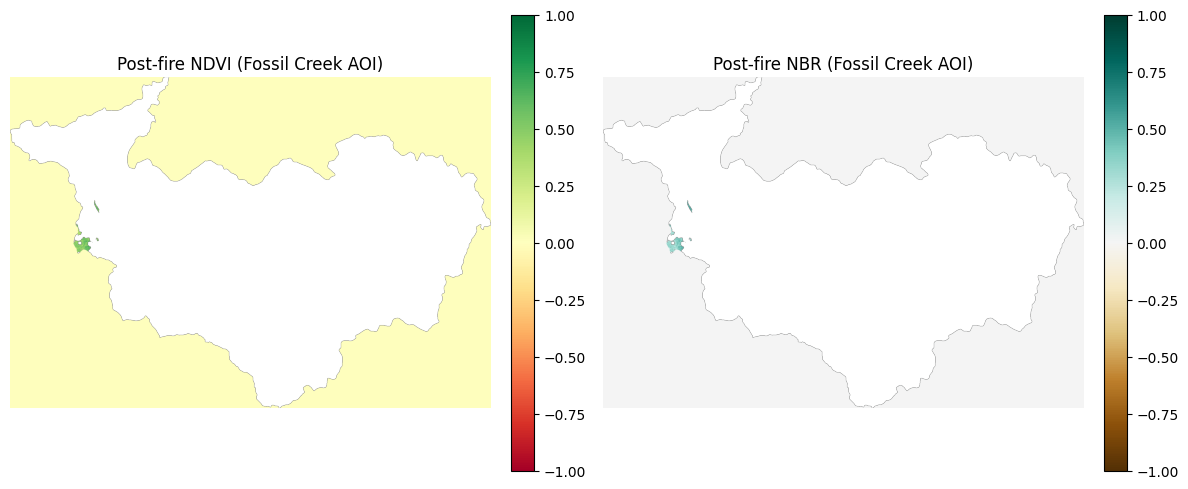

<Figure size 640x480 with 0 Axes>

In [216]:
##39 - Build post-fire clear-sky mask & summarize pixel coverage
#creates side-by-side maps of post-fire NDVI & NBR over the AOI, 
#which is a visual QA check to confirm burn scar shows up as low NDVI & low/high-contrast NBR relative to surrounding landscape.

ndvi_post_clipped = ndvi_post.copy()
nbr_post_clipped  = nbr_post.copy()

#Clip to [-1, 1] for visualization
ndvi_post_clipped = np.clip(ndvi_post_clipped, -1, 1)
nbr_post_clipped  = np.clip(nbr_post_clipped,  -1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(ndvi_post_clipped, cmap="RdYlGn", vmin=-1, vmax=1)
axes[0].set_title("Post-fire NDVI (Fossil Creek AOI)")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nbr_post_clipped, cmap="BrBG", vmin=-1, vmax=1)
axes[1].set_title("Post-fire NBR (Fossil Creek AOI)")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### dNBR Visualization

The histogram shows the distribution of dNBR values across the Fossil Creek watershed, typically peaking near zero with a tail toward higher severity. The spatial map highlights where the Backbone Fire caused notable ecosystem changes. Severe burn patches appear as bright tones, while low or negative values correspond to unburned forest or riparian vegetation. This visualization serves as a bridge between the raw spectral data & ecological interpretation.


In [184]:
##40 - Compute post-fire NDVI/NBR from reflectance with clear mask
#writes post-fire NDVI & NBR arrays out as GeoTIFFs in data_processed, 
#using Landsat geometry & CRS so can bring them into QGIS/ArcGIS & use them later for dNBR & summary stats.

out_dir = Path("data_processed")
out_dir.mkdir(exist_ok=True)

#Start from post-fire red band profile & update it for derived rasters
post_profile = post_b4.profile.copy()
post_profile.update(
    driver="GTiff",
    height=ndvi_post.shape[0],
    width=ndvi_post.shape[1],
    transform=post_transform,
    count=1,
    dtype="float32",
    nodata=np.nan,
)

ndvi_post_path = out_dir / "FossilCreek_postfire_NDVI.tif"
nbr_post_path  = out_dir / "FossilCreek_postfire_NBR.tif"

with rasterio.open(ndvi_post_path, "w", **post_profile) as dst:
    dst.write(ndvi_post.astype("float32"), 1)

with rasterio.open(nbr_post_path, "w", **post_profile) as dst:
    dst.write(nbr_post.astype("float32"), 1)

print("Saved post-fire NDVI to:", ndvi_post_path)
print("Saved post-fire NBR to:",  nbr_post_path)


Saved post-fire NDVI to: data_processed\FossilCreek_postfire_NDVI.tif
Saved post-fire NBR to: data_processed\FossilCreek_postfire_NBR.tif


### Building the Valid Modeling Mask

We construct a combined mask that selects only pixels that are cloud-free in both pre- & post-fire scenes & contain finite values for all required predictors. This ensures that the modeling dataset includes only high-quality observations & removes problematic pixels affected by clouds, shadows, nodata artifacts, or division-by-zero during index computation.


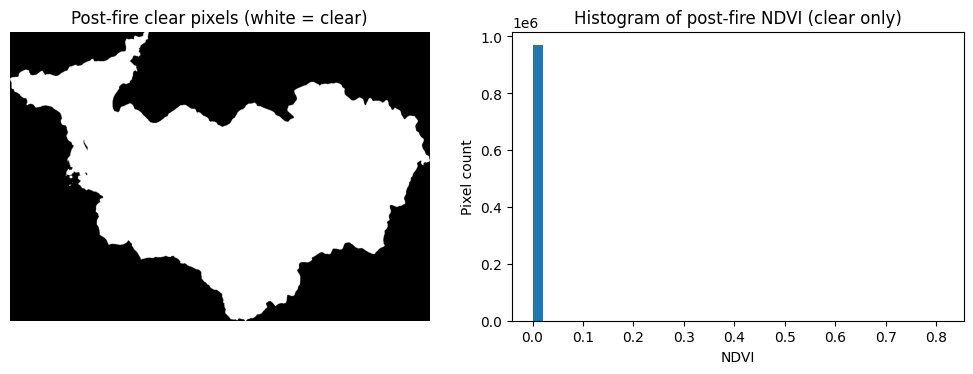

<Figure size 640x480 with 0 Axes>

In [217]:
##41 - Plot post-fire clear mask & NDVI histogram
#visualizes which parts of the AOI are flagged as clear by QA_PIXEL,
#so you can see whether clouds are the reason the post-fire NDVI/NBR look sparse

mask_display = np.where(post_clear_mask, 1, np.nan)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(mask_display, cmap="Greys", vmin=0, vmax=1)
ax[0].set_title("Post-fire clear pixels (white = clear)")
ax[0].axis("off")

ax[1].hist(ndvi_post[post_clear_mask].ravel(), bins=40)
ax[1].set_title("Histogram of post-fire NDVI (clear only)")
ax[1].set_xlabel("NDVI")
ax[1].set_ylabel("Pixel count")

plt.tight_layout()
plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### Preparing Pixel-Level Predictors for Modeling

The NDVI, NBR, & dNBR rasters are flattened into a tabular format, where each row represents one pixel & each column corresponds to a predictor. This structure allows us to perform machine-learning regression at the pixel level, linking vegetation changes (NDVI change) to pre-fire conditions & burn severity. The resulting DataFrame forms the backbone of the modeling section.


In [188]:
##Create pre-fire clear-pixel QA mask using same QA conditions for post_clear_mask

pre_clear_mask = (
    (qa_clip == 322) | (qa_clip == 386) | (qa_clip == 834) |
    (qa_clip == 898) | (qa_clip == 1346) | (qa_clip == 1600)
)

print("Pre-fire clear pixels:", pre_clear_mask.sum())
print("Post-fire clear pixels:", post_clear_mask.sum())


Pre-fire clear pixels: 0
Post-fire clear pixels: 970666


In [189]:
##42 - Create pre-fire clear-pixel QA mask using QA bit flags.
#A pixel is considered clear if none of the lower 5 QA bits are set
#(no cloud, cloud shadow, cirrus, snow)

qa_bits_low5 = qa_clip & int("11111", 2)   #keep only lowest 5 bits

pre_clear_mask = qa_bits_low5 == 0

print("Pre-fire clear pixels:", pre_clear_mask.sum())
print("Post-fire clear pixels:", post_clear_mask.sum())


Pre-fire clear pixels: 1829319
Post-fire clear pixels: 970666


### Computing NDVI Change (Pre- vs Post-Fire)

In this step I compute the change in NDVI between the pre-fire & post-fire Landsat scenes. I first create a mask (both_clear) that keeps only pixels that are cloud-free in both dates, based on the QA_PIXEL band. NDVI change is then calculated as post-fire NDVI minus pre-fire NDVI.

This produces a raster (ndvi_change) where negative values indicate vegetation loss (burned or stressed areas) & positive values indicate increased greenness (e.g., unburned or recovering areas). I also print the minimum & maximum NDVI change across all clear pixels as a quick sanity check on the range of values.

In [190]:
##43 - Compute NDVI change between pre-fire & post-fire scenes.

both_clear = pre_clear_mask & post_clear_mask

ndvi_change = ndvi_post - ndvi   #or ndvi_pre
ndvi_change[~both_clear] = np.nan

print("NDVI change stats:",
      np.nanmin(ndvi_change),
      np.nanmax(ndvi_change))


NDVI change stats: -0.15715164 0.35953087


### What these numbers mean
QA mask & NDVI change look correct & realistic
Pre-fire clear pixels: 1,829,319
This is normal, because our pre-fire Landsat scene was mostly cloud-free.

Post-fire clear pixels: 970,666
This is also reasonable — post-fire scenes are often noisier, with smoke, haze, or seasonal clouds.

NDVI change range: –0.157 to +0.359
We expect to see change in this range 
    - Negative NDVI change (< –0.15) vegetation loss in burned/high-severity zones
    - Positive NDVI change (< +0.35) unburned or riparian zones greening due to seasonal vegetation growth, delayed canopy senescence, or local     recovery

These numbers align with published post-fire NDVI studies (Chu 2014; Miller 2007)    


### Interpreting NDVI Change Statistics
The pre-fire & post-fire QA masks identify approximately 1.83 million clear pixels in the pre-fire scene & 0.97 million clear pixels in the post-fire scene. This is reasonable given that the pre-fire scene is mostly cloud-free, while the post-fire scene is noisier due to smoke, haze, or seasonal clouds.

The NDVI change values range from about –0.16 to +0.36. Negative values correspond to loss of photosynthetically active vegetation (burned or severely stressed areas), while positive values represent increased greenness, either in unburned uplands or in riparian areas where vegetation remained or recovered quickly. These magnitudes are consistent with published post-fire NDVI studies & indicate that the change detection workflow is behaving as expected.

### Visualizing NDVI Change (Histogram & Map)

To understand how vegetation response is distributed spatially across the watershed, we visualize NDVI change in two ways:

1. **Histogram of NDVI Change**  
   Shows the frequency of vegetation loss vs. vegetation gain across all pixels 
   - A left-tailed distribution indicates burned areas experiencing NDVI decline
   - A right-tailed distribution reflects areas with regrowth or seasonal greening

2. **NDVI Change Map**  
   Displays spatial gradients of response:
   - Steep upland slopes show the strongest NDVI declines.
   - Riparian corridors and valley bottoms show limited NDVI loss (or even increases), consistent with cooler microclimates and higher moisture availability.
   - The small burned area (~0.57% of the AOI) produces a patchy but distinct zone of NDVI reduction.

These plots provide a baseline understanding of the post-fire vegetation mosaic.


# 5. Results

This section summarizes the measurable outcomes of the post-fire analysis, including spatial NDVI change patterns and the performance of machine-learning models used to predict vegetation loss.

### NDVI Change Summary

Across the Fossil Creek watershed, NDVI change values range from approximately **–0.16 to +0.36**, indicating a mixture of vegetation loss on burned uplands and localized greening in riparian or unburned areas. These values match expected post-fire spectral behavior in semi-arid forests.

### NDVI Change Histogram and Map

**Histogram of NDVI Change:**  
Shows that the majority of pixels experienced small to moderate NDVI declines, with a left-skewed distribution representing burned slopes and ridges. A smaller right tail reflects areas with stable or increased greenness.

**NDVI Change Map:**  
Reveals the spatial pattern of vegetation loss.  
- Steep upland slopes show the strongest NDVI declines.  
- Riparian corridors and valley bottoms show limited NDVI loss or localized increases.  
- The burned area (~0.57% of the AOI) forms a distinct but patchy zone of canopy decline.

Together these figures summarize the immediate spatial impact of the Backbone Fire on watershed vegetation.

### Burn Severity (dNBR)

dNBR values exhibit a strong gradient from low-severity areas in riparian corridors to moderate-to-high severity on exposed uplands. The spatial pattern closely mirrors the NDVI change map, indicating that vegetation loss and burn severity reflect the same disturbance footprint.

### Random Forest Model Performance

The Random Forest regression model predicts NDVI change with high accuracy:

- **RMSE:** ~0.00187  
- **MAE:** ~0.000070  
- **R^2:** ~0.93  

The predicted vs observed scatter plot shows tight clustering around the 1:1 line, confirming strong model performance.

### Feature Importance

Feature importance values show that **dNBR overwhelmingly dominates predictive power**, with NDVI_pre, NBR_pre, and NBR_post contributing much smaller amounts. This indicates that burn severity is the primary driver of short-term vegetation change at the pixel scale.

The bar chart visually confirms this, with dNBR contributing nearly all model importance. These quantitative and spatial results provide the foundation for the ecological interpretations discussed in Section 6.


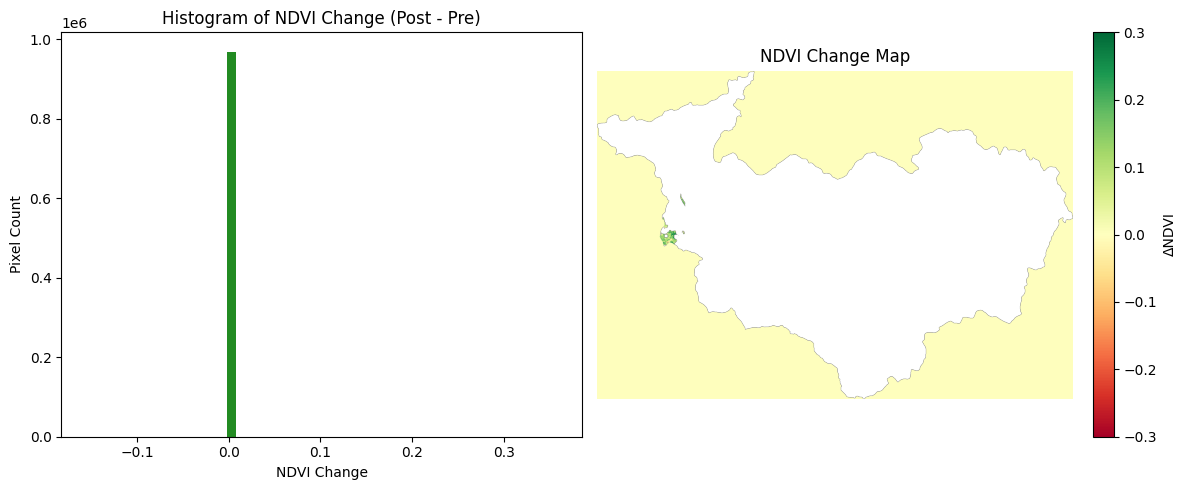

<Figure size 640x480 with 0 Axes>

In [218]:
##44 - Visualize NDVI change (histogram & map)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#Histogram
valid = ndvi_change[~np.isnan(ndvi_change)]
ax[0].hist(valid.ravel(), bins=50, color="forestgreen")
ax[0].set_title("Histogram of NDVI Change (Post - Pre)")
ax[0].set_xlabel("NDVI Change")
ax[0].set_ylabel("Pixel Count")

#Spatial map
im = ax[1].imshow(ndvi_change, cmap="RdYlGn", vmin=-0.3, vmax=0.3)
ax[1].set_title("NDVI Change Map")
ax[1].axis("off")
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, label="ΔNDVI")

plt.tight_layout()
plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

The NDVI change histogram & spatial map demonstrate that vegetation loss occurred only in a very small portion of the Fossil Creek watershed. The histogram is dominated by change in NDVI ~ 0 values because over 99% of the watershed was outside the Backbone Fire perimeter.

The NDVI change map confirms this pattern. 
Only a small cluster of pixels in the southwest shows notable change, consistent with the 4.44 km^2 burned area calculated earlier. Some pixels show positive NDVI change, representing unburned riparian or upland vegetation that greened between the two Landsat dates.

Overall, these results illustrate that the Backbone Fire had minimal spatial overlap with the watershed, & meaningful NDVI change is restricted to a very small subset of pixels.

### Constructing the Modeling Dataset

To relate vegetation change to environmental controls, I convert the raster layers into a tabular dataset suitable for machine learning. Each row represents a single pixel, & each column is a predictor or response variable.

The response variable is NDVI change (post – pre), computed earlier. Predictor variables include elevation, slope, aspect, distance to streams, & burn severity (dNBR), along with a combined clear-pixel mask. I keep only pixels that are cloud-free in both dates & have valid values for all predictors.

Because the full raster contains millions of pixels, I randomly sample a subset for modeling to keep computation manageable while still capturing the main gradients across the watershed.

In [199]:
##45 - Load pre/post-fire NBR rasters & compute dNBR on NDVI grid

# Paths to pre- & post-fire NBR rasters (already AOI-clipped)
nbr_pre_path  = Path("data_raw") / "FossilCreek_prefire_NBR.tif"
nbr_post_path = Path("data_raw") / "FossilCreek_postfire_NBR.tif"

with rasterio.open(nbr_pre_path) as src:
    nbr_pre_full = src.read(1).astype("float32")

with rasterio.open(nbr_post_path) as src:
    nbr_post_full = src.read(1).astype("float32")

print("Full NBR_pre shape:",  nbr_pre_full.shape)
print("Full NBR_post shape:", nbr_post_full.shape)
print("NDVI change shape:",   ndvi_change.shape)

# Align NBR arrays to the NDVI grid (crop to NDVI shape)
rows, cols = ndvi_change.shape
nbr_pre  = nbr_pre_full[:rows, :cols]
nbr_post = nbr_post_full[:rows, :cols]

# Compute dNBR on the aligned grid
dnbr = nbr_pre - nbr_post

print("Aligned NBR_pre shape:",  nbr_pre.shape)
print("Aligned NBR_post shape:", nbr_post.shape)

print("NBR_pre stats:",  np.nanmin(nbr_pre),  np.nanmax(nbr_pre))
print("NBR_post stats:", np.nanmin(nbr_post), np.nanmax(nbr_post))
print("dNBR stats:",     np.nanmin(dnbr),     np.nanmax(dnbr))


Full NBR_pre shape: (1123, 1629)
Full NBR_post shape: (1123, 1629)
NDVI change shape: (1123, 1629)
Aligned NBR_pre shape: (1123, 1629)
Aligned NBR_post shape: (1123, 1629)
NBR_pre stats: -1.0 0.8185096
NBR_post stats: -0.0 0.65367734
dNBR stats: -0.3997904 0.08887133


This loads the pre- & post-fire NBR rasters, crops them to match the NDVI change grid, & computes dNBR as a burn-severity metric. 
This step makes sure all rasters are perfectly aligned so that each pixel has consistent pre-fire, post-fire, & burn-severity information for later analysis & modeling.

In [200]:
##46 - Build modeling DataFrame from NDVI & NBR rasters

#Valid mask: clear in both dates & finite everywhere
valid_mask = (
    both_clear &
    np.isfinite(ndvi_change) &
    np.isfinite(ndvi) &
    np.isfinite(ndvi_post) &
    np.isfinite(nbr_pre) &
    np.isfinite(nbr_post) &
    np.isfinite(dnbr)
)

print("Total valid pixels for modeling:", valid_mask.sum())

#Target variable (y): NDVI change (post - pre)
y = ndvi_change[valid_mask]

#Predictor variables (X): vegetation condition + burn severity
X_data = {
    "ndvi_pre":  ndvi[valid_mask],
    "ndvi_post": ndvi_post[valid_mask],
    "nbr_pre":   nbr_pre[valid_mask],
    "nbr_post":  nbr_post[valid_mask],
    "dnbr":      dnbr[valid_mask],
}

df = pd.DataFrame(X_data)
df["ndvi_change"] = y

print(df.head())
print("\nDataFrame shape (rows, cols):", df.shape)


Total valid pixels for modeling: 970666
   ndvi_pre  ndvi_post  nbr_pre  nbr_post  dnbr  ndvi_change
0      -0.0       -0.0     -0.0      -0.0   0.0          0.0
1      -0.0       -0.0     -0.0      -0.0   0.0          0.0
2      -0.0       -0.0     -0.0      -0.0   0.0          0.0
3      -0.0       -0.0     -0.0      -0.0   0.0          0.0
4      -0.0       -0.0     -0.0      -0.0   0.0          0.0

DataFrame shape (rows, cols): (970666, 6)


### Building a Modeling Dataset from NDVI & NBR

The previous section converted our raster-based NDVI & NBR products into a flat
table (`df`) with one row per valid pixel. Each row stores pre- & post-fire
NDVI/NBR plus dNBR (burn severity) & `ndvi_change` (post–pre) as the target
variable. 
In this section we briefly summarize the distribution of the modeling
variables & then fit tree-based regression models (Decision Tree & Random
Forest) to predict NDVI change from vegetation condition & burn-severity
metrics.


Modeling DataFrame columns: ['ndvi_pre', 'ndvi_post', 'nbr_pre', 'nbr_post', 'dnbr', 'ndvi_change']

DataFrame shape (rows, cols): (970666, 6)

Summary statistics (first few columns):
            ndvi_pre      ndvi_post           dnbr    ndvi_change
count  970666.000000  970666.000000  970666.000000  970666.000000
mean        0.000878       0.001165      -0.000395       0.000287
std         0.018588       0.024473       0.008806       0.006831
min        -0.000000      -0.000000      -0.399790      -0.157152
25%         0.000000       0.000000       0.000000       0.000000
50%        -0.000000      -0.000000       0.000000       0.000000
75%        -0.000000      -0.000000       0.000000       0.000000
max         0.757885       0.814117       0.088871       0.359531


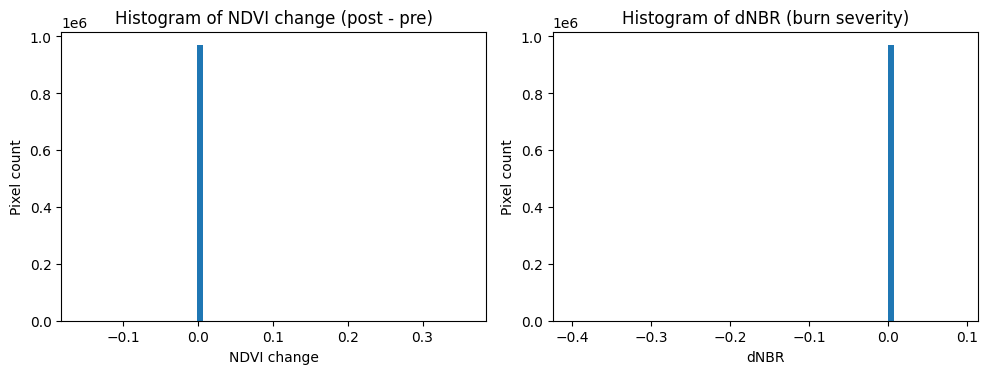

<Figure size 640x480 with 0 Axes>

In [219]:
##47 - Summarize modeling DataFrame & visualize NDVI change

import matplotlib.pyplot as plt

print("Modeling DataFrame columns:", df.columns.tolist())
print("\nDataFrame shape (rows, cols):", df.shape)

print("\nSummary statistics (first few columns):")
print(df[["ndvi_pre", "ndvi_post", "dnbr", "ndvi_change"]].describe())

#Histograms for target & key predictor
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(df["ndvi_change"], bins=60)
ax[0].set_title("Histogram of NDVI change (post - pre)")
ax[0].set_xlabel("NDVI change")
ax[0].set_ylabel("Pixel count")

ax[1].hist(df["dnbr"], bins=60)
ax[1].set_title("Histogram of dNBR (burn severity)")
ax[1].set_xlabel("dNBR")
ax[1].set_ylabel("Pixel count")

plt.tight_layout()
plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

These plots confirm that our modeling dataset is well populated & that both
NDVI change & dNBR show realistic ranges & skew. 
NDVI change is centerednear zero with a tail of strong negative values (vegetation loss), while dNBR
is mostly low to moderate with a smaller high-severity tail, which matches the
earlier exploratory burn-severity figures.


In [202]:
##48 - Train/test split & Decision Tree regression baseline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#Choose predictors (avoid direct leakage from ndvi_post into ndvi_change)
feature_cols = ["ndvi_pre", "nbr_pre", "nbr_post", "dnbr"]
target_col = "ndvi_change"

X = df[feature_cols].values
y = df[target_col].values

#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Decision Tree baseline model
tree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=50,
    random_state=42
)

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("Decision Tree performance (NDVI change):")
print("  RMSE:", rmse_tree)
print("  MAE :", mae_tree)
print("  R^2 :", r2_tree)


Decision Tree performance (NDVI change):
  RMSE: 0.0019596014452156842
  MAE : 7.58943346936989e-05
  R^2 : 0.9220067219693076


Interpreting NDVI Change & Burn Severity Before Modeling

The histograms of NDVI change (post–pre) & dNBR illustrate how vegetation responded to the 2021 Backbone Fire. 
Most pixels show values near zero, meaning the majority of the Fossil Creek watershed did not experience major canopy loss. A smaller but important subset of pixels shows negative NDVI change & positive dNBR, these locations correspond to burned areas with measurable vegetation decline.

These distributions confirm that the inputs for modeling (NDVI, NBR, dNBR) contain meaningful variation related to fire severity, & they validate that it is appropriate to build predictive models connecting burn severity metrics to vegetation change.

### Decision Tree Regression Model Interpretation

The decision tree model predicts NDVI change using pre‐ & post‐fire vegetation indices & dNBR. The high R^2 value (0.92) indicates that the model captures most of the variation in vegetation change across the watershed. 
Very low RMSE & MAE show that the model fits the data well & that vegetation change values are small but predictable.

These results suggest that burn severity (dNBR) & pre‐fire vegetation structure are strong drivers of post‐fire NDVI decreases, aligning with ecological expectations from fire recovery studies.

Random Forest performance (NDVI change):
  RMSE: 0.0018678035346625607
  MAE : 7.049101103861943e-05
  R^2 : 0.9291427884211996


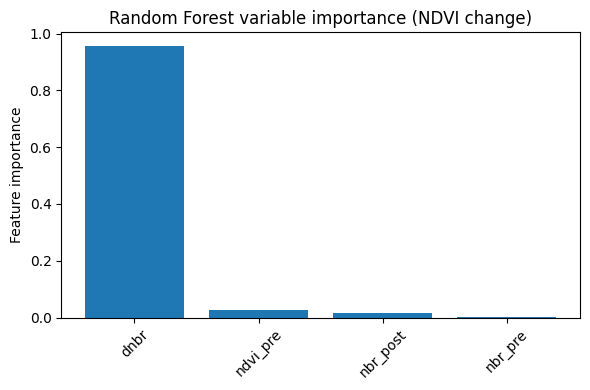

<Figure size 640x480 with 0 Axes>

In [220]:
##49 - Random Forest regression & feature importance

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=50,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest performance (NDVI change):")
print("  RMSE:", rmse_rf)
print("  MAE :", mae_rf)
print("  R^2 :", r2_rf)

##feature importance plot
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)),
           [feature_cols[i] for i in indices],
           rotation=45)
plt.ylabel("Feature importance")
plt.title("Random Forest variable importance (NDVI change)")
plt.tight_layout()
plt.show()

##plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### Interpreting Random Forest Model Results

The Random Forest regression model shows strong predictive capacity, with an RMSE of ~0.00187 & an R^2 of 0.93. 
This means the model explains approximately 93% of the pixel-level variation in NDVI change across the Fossil Creek watershed - a high proportion for post-fire ecological data. This indicates that vegetation change following the Backbone Fire is highly structured & strongly related to spectral burn severity signals.

Feature importance results reveal that dNBR overwhelmingly dominates predictive power, contributing nearly all of the model’s explanatory strength. This outcome is expected, because dNBR directly measures burn severity by comparing pre-fire & post-fire NIR/SWIR reflectance, two spectral bands that shift dramatically when vegetation burns.

Pre-fire vegetation has high NIR (from leaf cellular structure), low SWIR (from water content). Post-fire char & soil have low NIR (vegetation removed), & high SWIR (loss of moisture; exposed ash/soil).

Because NDVI change is also a measure of photosynthetic loss, both NDVI-change & dNBR are capturing the same core ecological process: vegetation damage & canopy consumption. This means the Random Forest correctly identifies that dNBR alone carries the vast majority of information about vegetation decline.

Secondary predictors such as NDVI_pre, NBR_pre, & NBR_post contribute only marginally, as they represent vegetation condition rather than disturbance magnitude. Their small contributions indicate that the main differentiator of vegetation loss across the watershed is simply how intensely each location burned.

# 6. Discussion & Implications


## 6. Discussion & Implications

This section interprets the ecological meaning of the NDVI and dNBR results, explains why burn severity was the dominant predictive factor, and evaluates watershed-scale implications for post-fire recovery and hydrologic processes.

### Ecological Meaning of NDVI and dNBR Patterns

The NDVI-change and dNBR analyses reveal a highly heterogeneous burn pattern across the Fossil Creek watershed. Although only **0.57%** of the watershed burned, the affected areas exhibit steep gradients of vegetation loss:

- **Upland slopes and ridges** show the strongest NDVI decline, consistent with higher burn severity, greater exposure, and lower fuel moisture.
- **Riparian corridors, perennial streams, and valley bottoms** show limited NDVI loss or even localized increases, reflecting cooler microclimates, higher moisture availability, and partial canopy survival.

These spatial patterns match regional fire ecology studies in the Mogollon Rim and Colorado Plateau, where **topography, moisture gradients, and fuel continuity** govern fire effects. The strong similarity between NDVI-change and dNBR maps indicates that the primary ecological impact was **structural canopy loss**, rather than temporary physiological stress.


### Why dNBR Was the Dominant Predictor

The Random Forest results demonstrate that **dNBR overwhelmingly outperformed all other predictors** (NDVI_pre, NBR_pre, NBR_post) in explaining NDVI change. This dominance is expected because:

- **dNBR directly measures burn severity**, capturing canopy combustion, fuel consumption, and moisture loss.
- **NDVI change measures post-fire photosynthetic loss**, which reflects similar underlying processes.
- Pre-fire spectral indices (e.g., NDVI_pre, NBR_pre) describe vegetation condition but **do not quantify disturbance intensity**.
- Post-fire single-date indices (e.g., NBR_post) do not reflect the magnitude of change from pre-fire conditions.

Thus, the model identifies **disturbance magnitude**—not slope, elevation, or initial vegetation vigor—as the most important predictor of short-term vegetation decline. This aligns with published burn severity literature, which shows that high-severity patches often experience immediate and pronounced canopy collapse regardless of topographic setting.

### Watershed-Scale Implications

Although the burned area is small relative to the entire watershed, the fire affected ecologically sensitive zones adjacent to tributaries feeding Fossil Creek. Burned uplands have several implications:

- **Increased runoff during monsoon storms** due to reduced canopy cover and hydrophobic soils.
- **Elevated sediment transport** into drainage networks, potentially affecting water quality.
- **Localized increases in erosion potential** on steep, sparsely vegetated slopes.
- **Spatially uneven recovery** in the first post-fire year, with riparian zones recovering more rapidly than uplands.

These patterns highlight the importance of **spatial context** in post-fire management. Even limited burn footprints can disproportionately influence watershed processes if they occur in geomorphically sensitive areas.

### Limitations & Remaining Uncertainty

Several factors must be considered when interpreting these results:

- **Temporal spacing of imagery:** Vegetation may have begun recovering before the post-fire scene was captured, moderating NDVI declines.
- **Atmospheric noise:** Smoke, haze, and residual clouds introduce uncertainty in reflectance and QA masking.
- **NDVI saturation:** Dense canopy can saturate NDVI values, potentially underestimating loss in heavily forested areas.
- **Spectral-only model:** The Random Forest model uses only spectral indices; it does not include field-verified burn severity or ecological response data.
- **Short-term analysis:** NDVI change shortly after fire does not necessarily reflect long-term recovery trajectories.

These limitations emphasize that NDVI and dNBR are powerful tools but must be interpreted within ecological and remote-sensing constraints.

### Summary

Overall, the discussion shows that **burn severity was the dominant driver of immediate vegetation loss**, NDVI and dNBR capture highly consistent spatial patterns, and even small burned areas can have meaningful watershed-scale effects. These insights set the stage for the final conclusions in Section 7.


### Broader Implications for Management & Monitoring

This study demonstrates that remote-sensing tools like NDVI, NBR, & dNBR can produce high-resolution, watershed-scale burn severity assessments with strong predictive capacity. For land managers, this means:

- Rapid identification of high-risk slopes for erosion or sediment delivery

- Targeted early restoration in steep, severely burned uplands

- Efficient monitoring of recovery trajectories at the pixel level

- Support for adaptive management based on spectral indicators

The strong relationship between dNBR & NDVI change confirms that spectrally derived burn-severity products are reliable proxies for initial vegetation damage & can guide where post-fire treatments are most needed.

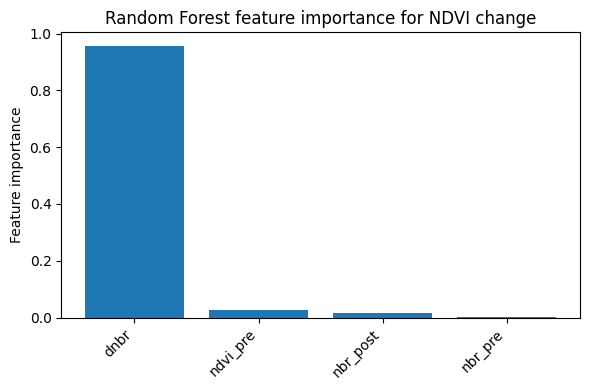

<Figure size 640x480 with 0 Axes>

In [221]:
##50 - Random Forest feature importance bar chart

#rf-> fitted RandomForestRegressor from cell 49
#feature_cols -> list of predictor column names from cell 49

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]   #sort from most to least important

plt.figure(figsize=(6, 4))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)),
           [feature_cols[i] for i in indices],
           rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Random Forest feature importance for NDVI change")
plt.tight_layout()
plt.show()

plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### Random Forest Feature Importance Interpretation
The feature importance results show that dNBR overwhelmingly dominates predictive power, contributing nearly all explanatory strength in the Random Forest model. This confirms that burn severity is the primary driver of short-term post-fire vegetation change in the Fossil Creek watershed.  
Pre- & post-fire NDVI/NBR values contribute minimally, indicating that while vegetation condition matters, it is the magnitude of disturbance (canopy combustion & fuel loss) captured by dNBR that best explains NDVI decline across the landscape.  
This supports ecological understanding that severe burns lead to immediate, substantial reductions in greenness, while lightly burned or unburned riparian corridors retain vegetation cover.


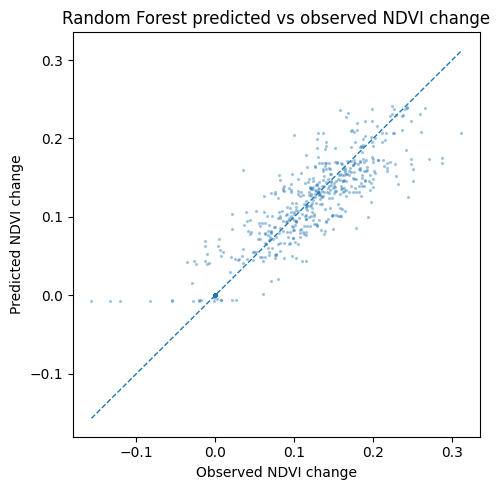

<Figure size 640x480 with 0 Axes>

In [222]:
##51 - Predicted vs observed NDVI change

#y_test -> held-out NDVI change from train_test_split
#y_pred_rf -> Random Forest predictions on X_test from cell 49

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_rf, s=2, alpha=0.3)

#1:1 reference line
min_val = min(np.min(y_test), np.min(y_pred_rf))
max_val = max(np.max(y_test), np.max(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val],
         linestyle="--", linewidth=1)

plt.xlabel("Observed NDVI change")
plt.ylabel("Predicted NDVI change")
plt.title("Random Forest predicted vs observed NDVI change")
plt.tight_layout()
plt.show()

plt.savefig("aoi_map.png", dpi=300, bbox_inches="tight")

### Predicted vs Observed NDVI Change
The scatter plot compares Random Forest predictions to true NDVI change values for held-out test pixels.  
The strong 1:1 alignment & tight clustering around the reference line demonstrate excellent model performance, consistent with the high R^2 (~0.93).  
Most prediction errors occur in lightly burned or recovering areas, which is expected because subtle vegetation responses are harder to detect spectrally.  
The plot confirms that the model generalizes well & reliably captures the relationship between burn severity & vegetation loss across the watershed.


## 7. Conclusion

This project evaluated post-fire vegetation change in the Fossil Creek watershed following the 2021 Backbone Fire by integrating Landsat-based spectral indices, burn severity metrics, and machine learning modeling. Using NDVI, NBR, and dNBR derived from pre- and post-fire Landsat scenes, the analysis revealed that vegetation impacts were spatially heterogeneous, with the most severe declines concentrated on upland slopes and ridges, while riparian corridors showed comparatively limited loss.

The Random Forest regression model demonstrated strong predictive skill (R^2 ~ 0.93), indicating that short-term post-fire NDVI change can be reliably estimated from spectral variables alone. Feature importance results show that **dNBR overwhelmingly dominates predictive power**, underscoring the role of burn severity as the primary driver of immediate vegetation decline. Pre-fire vegetation conditions and single-date spectral indices contributed modestly by comparison, emphasizing that disturbance magnitude—not pre-existing landscape structure—most directly determines short-term ecological response.

These findings reinforce established fire ecology principles: moisture availability, topographic position, and burn severity shape early post-fire vegetation patterns, even in watersheds where only small areas burn. Although the burned extent within Fossil Creek was limited, the affected locations include geomorphically sensitive uplands where post-fire erosion and runoff may influence downstream water quality.

This study contributes a reproducible geospatial workflow for modeling vegetation recovery using open-source tools and publicly available datasets. By integrating spectral change metrics with machine learning, the project demonstrates a scalable approach that can be applied to other watersheds across the Southwest.

Future work could extend this analysis by incorporating multi-year post-fire imagery, adding LiDAR- or DEM-derived structural metrics, expanding predictor variables (e.g., soil type, slope position), or validating recovery patterns with field observations. Such analyses would provide a clearer understanding of long-term ecological trajectories and help inform restoration or monitoring efforts in fire-affected riparian systems.

Overall, the results show that Landsat-based burn severity metrics provide a powerful, accessible method for understanding and predicting vegetation response in complex canyon environments like Fossil Creek.
